Setup

In [79]:
# %pip install paddlepaddle-gpu
# %pip install groq

In [80]:
# !wget https://github.com/googlefonts/noto-fonts/blob/main/hinted/ttf/NotoSansKannada/NotoSansKannada-Regular.ttf?raw=true -O NotoSansKannada-Regular.ttf

In [81]:
# !sudo mv NotoSansKannada-Regular.ttf /usr/share/fonts/

In [82]:
# !sudo fc-cache -f -v

In [83]:
# !fc-list | grep Kannada

# OCR with bounding boxes

In [84]:
from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt
from PIL import Image

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Path to your image
image_path = '/content/sample_data/berserk.png'

# Perform OCR on the image
result = ocr.ocr(image_path, cls=True)

# Extract bounding boxes and text
boxes = [line[0] for line in result[0]]
texts = [line[1][0] for line in result[0]]

# Print bounding boxes and text
for box, text in zip(boxes, texts):
    print(f"Box: {box}, Text: {text}")

# Visualize the results
image = Image.open(image_path).convert('RGB')

[2024/10/18 17:02:25] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [85]:
for idx in range(len(result)):
    res = result[idx]
    if res == None:
        continue
    boxes = [line[0] for line in res]
    txts = [line[1][0] for line in res]
    scores = [line[1][1] for line in res]
    im_show = draw_ocr(image, boxes, txts, scores, font_path = '/content/SourceCodePro-Regular.otf')
    im_show = Image.fromarray(im_show)
    im_show.save(f'result_page_{idx}.jpg')

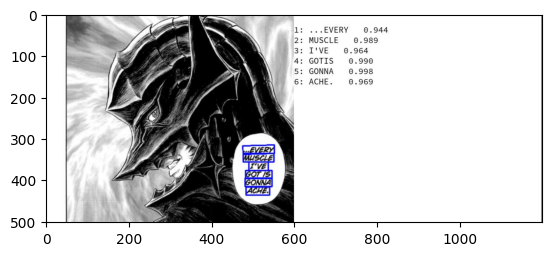

In [86]:
import cv2
plt.imshow(cv2.imread('result_page_0.jpg'))

# Translation

In [87]:
# groq_translation.py
import json
from typing import Optional

from groq import Groq
from pydantic import BaseModel

# Set up the Groq client
client = Groq(api_key="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")

# Model for the translation
class Translation(BaseModel):
    text: str
    comments: Optional[str] = None


# Translate text using the Groq API
def groq_translate(query, from_language, to_language):
    # Create a chat completion
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": f"You are a helpful assistant that translates text from {from_language} to {to_language}."
                           f"You will only reply with the translation text and nothing else in JSON."
                           f" The JSON object must use the schema: {json.dumps(Translation.model_json_schema(), indent=2)}",
            },
            {
                "role": "user",
                "content": f"Translate '{query}' from {from_language} to {to_language}."
            }
        ],
        model="llama3-70b-8192", # "llama-3.2-90b-text-preview"
        temperature=0.2,
        max_tokens=1024,
        stream=False,
        response_format={"type": "json_object"},
    )
    # Return the translated text
    return Translation.model_validate_json(chat_completion.choices[0].message.content)

In [88]:
response = groq_translate("hi how are you", from_language="english", to_language="hindi")
text = response.text
text

'नमस्ते कैसे हो'

In [89]:
response = groq_translate("an apple a day keeps the doctor away", from_language="english", to_language="kannada")
text = response.text
text

'ಒಂದು ಸೇಬು ದಿನಕ್ಕೆ ವೈದ್ಯರನ್ನು ದೂರವಿಡುತ್ತದೆ'

In [90]:
response = groq_translate("Are you made of stardust? Because every moment with you feels like a glimpse of the universe", from_language="english", to_language="kannada")
text = response.text
text

'ನೀವು ಸ್ಟಾರ್ಡಸ್ಟ್ ಮಾಡಿದ್ದೀರಾ? ಏಕೆಂದರೆ ನೀವು ಜೊತೆಯಲ್ಲಿ ಕಳೆದ ಪ್ರತಿ ಕ್ಷಣವೂ ವಿಶ್ವದ ಒಂದು ಅಂಶವನ್ನು ನೋಡುವಂತೆ ಇದೆ'

# Combining the two

In [91]:
boxes

[[[416.0, 278.0], [483.0, 276.0], [483.0, 294.0], [417.0, 296.0]],
 [[417.0, 294.0], [482.0, 294.0], [482.0, 312.0], [417.0, 312.0]],
 [[429.0, 312.0], [470.0, 312.0], [470.0, 330.0], [429.0, 330.0]],
 [[422.0, 330.0], [478.0, 330.0], [478.0, 347.0], [422.0, 347.0]],
 [[421.0, 346.0], [478.0, 346.0], [478.0, 364.0], [421.0, 364.0]],
 [[423.0, 365.0], [473.0, 365.0], [473.0, 382.0], [423.0, 382.0]]]

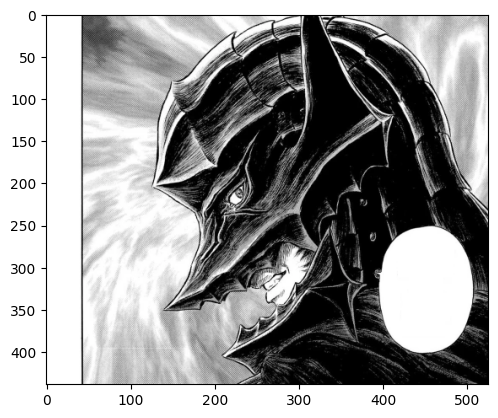

In [92]:
# prompt: these are the contents of boxes : [[[416.0, 278.0], [483.0, 276.0], [483.0, 294.0], [417.0, 296.0]],
#  [[417.0, 294.0], [482.0, 294.0], [482.0, 312.0], [417.0, 312.0]],
#  [[429.0, 312.0], [470.0, 312.0], [470.0, 330.0], [429.0, 330.0]],
#  [[422.0, 330.0], [478.0, 330.0], [478.0, 347.0], [422.0, 347.0]],
#  [[421.0, 346.0], [478.0, 346.0], [478.0, 364.0], [421.0, 364.0]],
#  [[423.0, 365.0], [473.0, 365.0], [473.0, 382.0], [423.0, 382.0]]]. Draw a white box in the numpy image called 'image' and store the contents in a new image

import numpy as np
from PIL import Image

# Assuming 'image' is your NumPy image and 'boxes' is the list of bounding boxes

image_np = np.array(image)  # Convert PIL Image to NumPy array if needed

new_image = image_np.copy()  # Create a copy of the image to draw on

for box in boxes:
  x1, y1 = int(min(box[0][0], box[1][0])), int(min(box[0][1], box[1][1]))
  x2, y2 = int(max(box[2][0], box[3][0])), int(max(box[2][1], box[3][1]))
  cv2.rectangle(new_image, (x1, y1), (x2, y2), (255, 255, 255), -1)  # Draw a white filled rectangle

new_image_pil = Image.fromarray(new_image)
# Now you can save or display the new_image_pil
new_image_pil.save('image_with_white_boxes.jpg')
plt.imshow(new_image_pil)

## naive method of translating ocr text

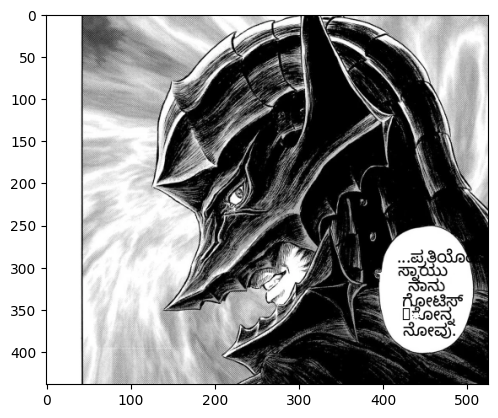

In [93]:
# prompt: modify this so that the text is written onto a new image called "translated_image", with the text written on the coordinates specified by box: [[416.0, 278.0], [483.0, 276.0], [483.0, 294.0], [417.0, 296.0]]. The original image is new_image_pil. Modify this code for it :
# for box, text in zip(boxes, texts):
#     translated_text = groq_translate(text, from_language="english", to_language="kannada").text

from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json
from typing import Optional
from groq import Groq
from pydantic import BaseModel
import numpy as np
from PIL import ImageDraw, ImageFont

translated_image = new_image_pil.copy()
draw = ImageDraw.Draw(translated_image)
font = ImageFont.truetype("NotoSansKannada-Regular.ttf", size=20)


for box, text in zip(boxes, texts):
    translated_text = groq_translate(text, from_language="english", to_language="kannada").text
    # Assuming 'box' is a list of coordinates [x1, y1, x2, y2]
    x1, y1 = int(box[0][0]), int(box[0][1])
    x2, y2 = int(box[2][0]), int(box[2][1])

    # Calculate the center point of the bounding box
    # x_center = (x1 + x2) // 2
    # y_center = (y1 + y2) // 2
    # Define coordinates for text placement within the box
    text_x = x1
    text_y = y1

    draw.text((text_x, text_y), translated_text, fill=(0, 0, 0), font=font)

# Save the image with the translated text
translated_image.save("translated_image.jpg")

plt.imshow(translated_image)

## here, we can see that it doesn't group the sentences properly --> which results in incorrect translation.

In [94]:
boxes

[[[416.0, 278.0], [483.0, 276.0], [483.0, 294.0], [417.0, 296.0]],
 [[417.0, 294.0], [482.0, 294.0], [482.0, 312.0], [417.0, 312.0]],
 [[429.0, 312.0], [470.0, 312.0], [470.0, 330.0], [429.0, 330.0]],
 [[422.0, 330.0], [478.0, 330.0], [478.0, 347.0], [422.0, 347.0]],
 [[421.0, 346.0], [478.0, 346.0], [478.0, 364.0], [421.0, 364.0]],
 [[423.0, 365.0], [473.0, 365.0], [473.0, 382.0], [423.0, 382.0]]]

In [95]:
texts

['...EVERY', 'MUSCLE', "I'VE", 'GOTIS', 'GONNA', 'ACHE.']

In [96]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You must convert the given array of strings into a coherent sentence",
        },
        {
            "role": "user",
            "content": f"{texts}",
        }
    ],
    model="llama3-70b-8192",
)

coherent_sentence = chat_completion.choices[0].message.content
print(coherent_sentence)

Here's the converted sentence:

"Every muscle I've got is gonna ache."


In [97]:
translated_text = groq_translate(coherent_sentence, from_language="english", to_language="kannada").text
translated_text

'ನಾನು ಹೊಂದಿರುವ ಪ್ರತಿಯೊಂದು ಸ್ನಾಯು ನೋವು ಉಂಟಾಗುತ್ತದೆ.'

In [98]:
boxes

[[[416.0, 278.0], [483.0, 276.0], [483.0, 294.0], [417.0, 296.0]],
 [[417.0, 294.0], [482.0, 294.0], [482.0, 312.0], [417.0, 312.0]],
 [[429.0, 312.0], [470.0, 312.0], [470.0, 330.0], [429.0, 330.0]],
 [[422.0, 330.0], [478.0, 330.0], [478.0, 347.0], [422.0, 347.0]],
 [[421.0, 346.0], [478.0, 346.0], [478.0, 364.0], [421.0, 364.0]],
 [[423.0, 365.0], [473.0, 365.0], [473.0, 382.0], [423.0, 382.0]]]

In [99]:
def get_bounding_box(rectangle):
    """
    Given a rectangle defined by its corner coordinates, return the bounding box.

    Parameters:
    - rectangle: A list of four points, where each point is a list of [x, y].

    Returns:
    - A tuple (x_min, y_min, x_max, y_max) representing the bounding box.
    """
    x_coords = [point[0] for point in rectangle]
    y_coords = [point[1] for point in rectangle]

    x_min = min(x_coords)
    y_min = min(y_coords)
    x_max = max(x_coords)
    y_max = max(y_coords)

    return (x_min, y_min, x_max, y_max)

# Example input
rectangles = [
    [[416.0, 278.0], [483.0, 276.0], [483.0, 294.0], [417.0, 296.0]],
    [[417.0, 294.0], [482.0, 294.0], [482.0, 312.0], [417.0, 312.0]],
    [[429.0, 312.0], [470.0, 312.0], [470.0, 330.0], [429.0, 330.0]],
    [[422.0, 330.0], [478.0, 330.0], [478.0, 347.0], [422.0, 347.0]],
    [[421.0, 346.0], [478.0, 346.0], [478.0, 364.0], [421.0, 364.0]],
    [[423.0, 365.0], [473.0, 365.0], [473.0, 382.0], [423.0, 382.0]]
]

# Get bounding boxes for each rectangle
bounding_boxes = [get_bounding_box(rect) for rect in rectangles]

bounding_boxes

[(416.0, 276.0, 483.0, 296.0),
 (417.0, 294.0, 482.0, 312.0),
 (429.0, 312.0, 470.0, 330.0),
 (422.0, 330.0, 478.0, 347.0),
 (421.0, 346.0, 478.0, 364.0),
 (423.0, 365.0, 473.0, 382.0)]

## one way to overcome the incorrect grouping is by merging overlapping boxes/ boxes with common edges into one, and then considering each "big" group of texts as one sentence : this results in more accurate translation

In [100]:
def merge_bounding_boxes_with_texts(bboxes, texts, horizontal_threshold=10, vertical_threshold=15):
    """
    Merge bounding boxes and corresponding texts that are close to each other into larger boxes.

    Parameters:
    - bboxes: List of bounding boxes (x_min, y_min, x_max, y_max)
    - texts: List of texts corresponding to the bounding boxes
    - horizontal_threshold: Max horizontal distance to merge
    - vertical_threshold: Max vertical distance to merge

    Returns:
    - List of merged bounding boxes and corresponding texts
    """
    if len(bboxes) == 0 or len(texts) == 0:
        return [], []

    # Sort bounding boxes and texts by the y coordinate (top-left corner)
    indexed_bboxes = sorted(enumerate(bboxes), key=lambda x: x[1][1])
    sorted_texts = [texts[i] for i, _ in indexed_bboxes]
    sorted_bboxes = [b[1] for b in indexed_bboxes]

    merged_boxes = []
    merged_texts = []
    current_box = list(sorted_bboxes[0])  # Start with the first bounding box
    current_text = sorted_texts[0]         # Start with the first text

    for i in range(1, len(sorted_bboxes)):
        next_box = sorted_bboxes[i]
        next_text = sorted_texts[i]

        # Check for vertical proximity
        if (next_box[1] <= current_box[3] + vertical_threshold) and \
           (next_box[0] <= current_box[2] + horizontal_threshold):
            # Extend current box and concatenate texts
            current_box[0] = min(current_box[0], next_box[0])  # Update x_min
            current_box[1] = min(current_box[1], next_box[1])  # Update y_min
            current_box[2] = max(current_box[2], next_box[2])  # Update x_max
            current_box[3] = max(current_box[3], next_box[3])  # Update y_max
            current_text += ' ' + next_text                      # Concatenate text
        else:
            # No proximity, add current box and text to merged list and start new ones
            merged_boxes.append(tuple(current_box))
            merged_texts.append(current_text)
            current_box = list(next_box)
            current_text = next_text

    # Add the last box and text
    merged_boxes.append(tuple(current_box))
    merged_texts.append(current_text)

    return merged_boxes, merged_texts

# Example bounding boxes (x_min, y_min, x_max, y_max) and their corresponding texts
# bounding_boxes = [
#     (50, 100, 80, 120),  # "A"
#     (50, 125, 80, 145),  # "man"
#     (50, 150, 80, 170),  # "is"
#     (150, 100, 180, 120), # "a"
#     (150, 125, 180, 145)  # "cat"
# ]
# texts = [
#     "A",
#     "man",
#     "is",
#     "a",
#     "cat"
# ]

merged_bboxes, merged_texts = merge_bounding_boxes_with_texts(bounding_boxes, texts)
print("Merged Bounding Boxes:", merged_bboxes)
print("Merged Texts:", merged_texts)

Merged Bounding Boxes: [(416.0, 276.0, 483.0, 382.0)]
Merged Texts: ["...EVERY MUSCLE I'VE GOTIS GONNA ACHE."]


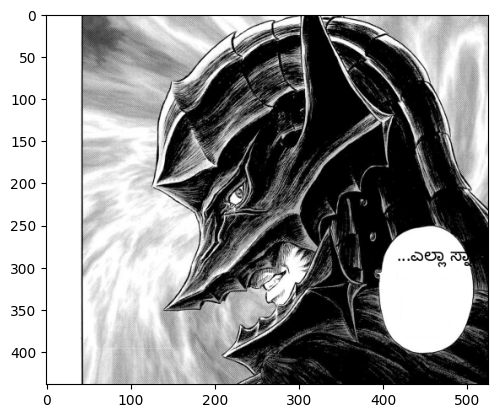

In [101]:
translated_image = new_image_pil.copy()
draw = ImageDraw.Draw(translated_image)
font = ImageFont.truetype("NotoSansKannada-Regular.ttf", size=20)


for box, text in zip(merged_bboxes, merged_texts):
    translated_text = groq_translate(text, from_language="english", to_language="kannada").text

    x1, y1, x2, y2 = box

    # Calculate the center point of the bounding box
    # x_center = (x1 + x2) // 2
    # y_center = (y1 + y2) // 2
    # Define coordinates for text placement within the box
    text_x = x1
    text_y = y1

    draw.text((text_x, text_y), translated_text, fill=(0, 0, 0), font=font)

# Save the image with the translated text
translated_image.save("translated_image_better.jpg")

plt.imshow(translated_image)

## ok, now a new problem is improper text filling

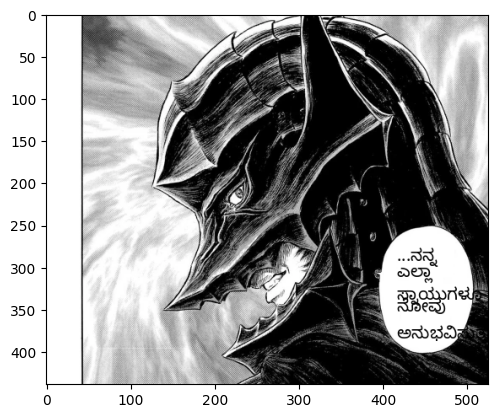

In [111]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_wrapped_text(draw, box, text, font, fill):
    x1, y1, x2, y2 = box
    max_width = x2 - x1
    # Split the text into words to allow for wrapping
    words = text.split()
    lines = []
    current_line = ""

    for word in words:
        # Check if adding the next word would exceed the box width
        test_line = current_line + word + " "
        # Calculate the bounding box for the test line
        bbox = draw.textbbox((x1, y1), test_line, font=font)
        if bbox[2] - bbox[0] <= max_width:  # bbox[2] is the right edge, bbox[0] is the left edge
            current_line = test_line
        else:
            # Save the current line and start a new one
            lines.append(current_line.strip())
            current_line = word + " "

    # Append the last line if there's any remaining text
    if current_line:
        lines.append(current_line.strip())

    # Draw each line of text, ensuring it fits within the box
    for i, line in enumerate(lines):
        # Calculate the height of the line
        line_height = draw.textbbox((x1, y1 + i), line, font=font)[3] - draw.textbbox((x1, y1 + i), line, font=font)[1]
        draw.text((x1, y1 + i * line_height), line, fill=fill, font=font)

# Load the image and create a draw object
translated_image = new_image_pil.copy()
draw = ImageDraw.Draw(translated_image)
font = ImageFont.truetype("NotoSansKannada-Regular.ttf", size=20)

for box, text in zip(merged_bboxes, merged_texts):
    translated_text = groq_translate(text, from_language="english", to_language="kannada").text
    draw_wrapped_text(draw, box, translated_text, font, fill=(0, 0, 0))

# Save the image with the translated text
translated_image.save("translated_image_better.jpg")

# Display the image
plt.imshow(translated_image)